In [12]:
### PREAMBLE
# Nonlinear modeling, overfitting, and regularization
# nonlinear.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Introduction

This set of notes really deals with two different topics: nonlinear modeling and the issue of generalization.  These are really two separate and distinct issues in machine learning, but they arise very naturally in contection with each other, and so we choose to introduce there at the same time here.  Nonetheless, it is important to also understand that they are different topics, and that generalization issues can arise for any type of classifier (linear or nonlinear), and than nonlinear hypothesis functions are of independent interest.  With this caveat in mind, though, let's see how they can arise together.

## Nonlinear modeling

To introduce the issue of nonlinear modeling, let's return our original example of predicting peak electrical demand from high temperature.  Let's load the data we used last time (though this time we won't load from the raw files but just load the data frame we created last time from a CSV file, to see how to load from the raw data, see the ML intro notes).

In [15]:
import pandas as pd
df = pd.read_csv("temp_demand.csv", index_col="Date")

Last time we considered the high temperature and peak demand in the summer months, obtained as follows.

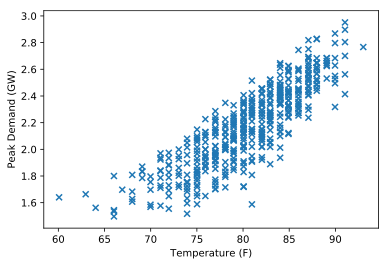

In [21]:
df_summer = df[list(map(lambda x : str(x)[4:6] in ["06", "07", "08"], df.index))].copy()
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")

As we discussed, the relationship between high temperature and electrical demand is well-modelled by a linear function during the summer months, when (at least in Pittsburgh), electricity in summer is dominated by air conditions (so with higher temperatures comes higher consumption).  However, this is clearly not the case of the entire year.  Indeed, if our previous linear model is to be believed then with lower temperatures we would continue to have lower and lower consumption (until, at some point, we'd start generating electricity).  Naturally, this is not the case, and if we instead consider the _entire_ year of temperature and peak dmeand, then another picture emerges.

(0, 95)

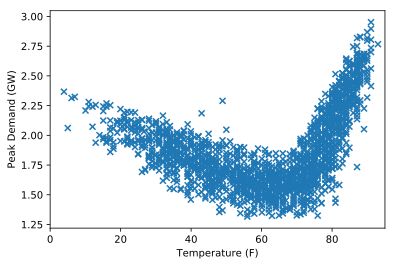

In [30]:
plt.scatter(df["Temp"], df["Load"], marker="x")
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.xlim([0,95])

This captures the effects we expect.  Although peak demand increases sharply with consumption after a high temperature of 70 degrees or so (precisely the range where air conditioning usually starts), below this the demand actually start to increase with _lower_ temperature -- though not with as steep a slope, due to the fact, for example, that most heating in Pittsburgh is done with gas rather than with electricity, and other loads that do increase with lower temperatures tend to be smaller in magnitude that air conditions.

If we were to fit a linear model to this data, it would look like the following.

(0, 95)

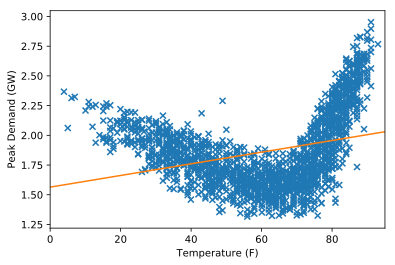

In [34]:
X = np.array([df["Temp"].values, np.ones(len(df))]).T
y = df["Load"].values
theta = np.linalg.solve(X.T @ X, X.T @ y)
plt.scatter(df["Temp"], df["Load"], marker="x")
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.plot([0,100], [theta[1], 100*theta[0]+theta[1]], 'C1')
plt.xlim([0,95])

In a very precise sense this _is_ the best fit to the data: it is the line that minimizes the sum of squared errors between the data points and the points on this line (remember, this is the definition of linear regression).  However, of course in another sense this is a very poor fit, as it misses the defining characteristic of the data, namely that peak demand has this characteristic of first gently decreasing with higher temperature up to about 70 degrees, then increasing rapidly.

To capture data of this type, we clearly want some way of expressing nonlinear relationships in the data.  Fortunately, this is possible without actually leaving the domain of so-called "linear regresion".  The trick we are going to use is a simple one: rather than have features $x^{(i)}$ which only include the "raw" inputs such as temperatuare (plus other raw inputs such as weekday indicators that we saw previously), we are going to make build features that include _nonlinear_ functions of the underlying inputs.  For example, we could choose the following features
\begin{equation}
x^{(i)} = \left [ \begin{array}{c} (\mathrm{HighTemperature}^{(i)})^2 \\
\mathrm{HighTemperature}^{(i)} \\ 1 \end{array} \right ]
\end{equation}
which also include a quadratic function of the high temperature variable.  If we choose this representation, then our linear hypothesis function $h_\theta(x) = \theta^Tx$ is now given by
\begin{equation}
h_\theta(x) = \theta_1 (\mathrm{HighTemperature}^{(i)})^2 + \theta_2 \mathrm{HighTemperature}^{(i)} + \theta_3
\end{equation}
which is a _quadratic_ function of the high temperature.  Importantly, however, the hypothesis function is still a linear function of the parameters, and so the exact same solution methods work as before (including the exact solution), just by passing a different feature matrix.

Let's see how this works in practice.  In this setting we're actually going to normalize features to the range $[-1,+1]$ even with the exactly least-squares solution for numerical reasons.  High polynomials get very large very quickly, and if we aren't careful it's easy to overload the range of double precision floating point values.

In [52]:
x = df["Temp"].values
min_x, max_x = x.min(), x.max()
x = 2*(x - min_x)/(max_x - min_x) - 1

def ls_poly(x, y, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X, X.T @ y)

theta = ls_poly(x, y, 2)
print(theta)

[ 1.19886894 -0.19235301  1.5888731 ]


Now that we've computed the solution, let's plot is as before.  Since our hypothesis is no longer a line we can't plot it by simply specifying two points, but the rough procedure works the same as before.

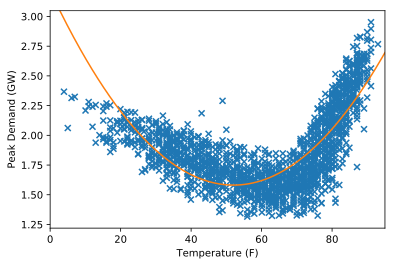

In [58]:
def plot_regression_poly(theta):
    degree = len(theta)-1
    xt0 = np.linspace(0,95, 400)
    xt = 2*(xt0 - min_x)/(max_x - min_x) - 1
    Xt = np.array([xt**i for i in range(degree,-1,-1)]).T
    yt = Xt @ theta
        
    plt.scatter(df["Temp"], df["Load"], marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (F)")
    plt.ylabel("Peak Demand (GW)")
    plt.xlim([0,95])
    plt.ylim(ylim)
    
plot_regression_poly(theta)

This looks better, but quadratic function is symmetric around its minimum point, and the data we're trying to fit is definitely not symmetric. Thus, we may want a cubic function.

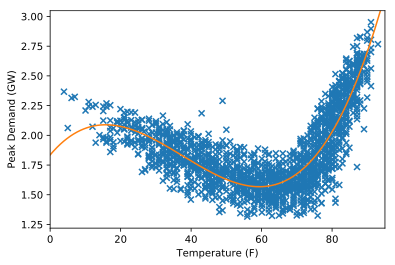

In [53]:
plot_regression_poly(ls_poly(x,y,3))

This looks better except for the low end, so maybe one more degree.

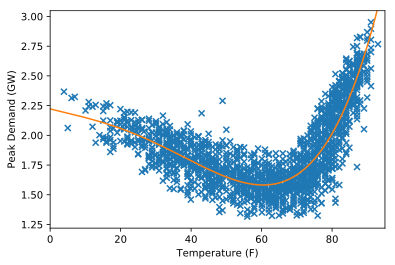

In [54]:
plot_regression_poly(ls_poly(x,y,4))

This is starting to look like a pretty good fit to the data.  But so far high degree has been better, so let's keep going, trying a degree 10 polynomial.

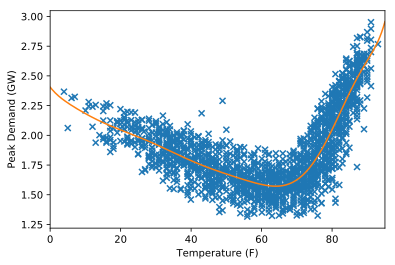

In [55]:
plot_regression_poly(ls_poly(x,y,10))

Still not bad.  Let's keep going.

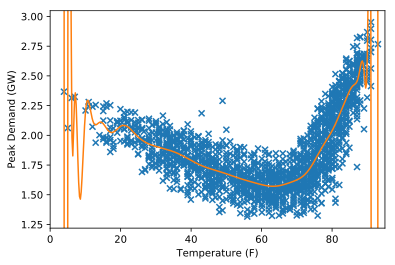

In [61]:
plot_regression_poly(ls_poly(x,y,100))

Something very bad has happened at this point.  Especially at the tail ends of the data, where the data points are spaced less closely, we start to get very odd patterns for the data.  But the important point is that this is actually a very good fit to the data from a least-squares perspective.  As you can see from the figure, the lines pass _exactly_ through many of the data point (most obvious on the left hand side of the plot), whereas for the "better" fits we had above, our function didn't pass exactly through those points, so actually suffered more loss.  But there is an obvious way in which the degree 100 polynomial fit, despite having _lower_ loss, is actually a worse approximation to the underlying data.  This brings us to the second topic of these notes, which is the issue of generlization and overfitting.

## Generalization and overfitting

Recall from our previous discussions that the canoncial machine learning problem that we solve with every algorithm is the following
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right)
\end{equation}
i.e., to minimize the sum of losses on the data set.  However, in a more fundamental way, this is not really our goal.  We ultimately do not care about achieving low loss specifically on the points that we are feeding into the algorithm: we already _know_ the true output for each of these data points, and if we want to "predict" these points precisely, we could just look up each point in a database (assuming we have some way of referring to the points uniquely).  What we _really_ want from a machine learning algorithm is the ability to predict will on _new_ data points _of the same type_ as those we learned our model on.  We don't care about knowing was the peak demand _was_ on previous days we have already seen; we care about being able to predict what the peak demand will _be_ tomorrow given the high temperature as input.

This discussion leads us to the notion of _generalization error_.  We're going to define this a bit formally (though not nearly as formally as would be done, for instance, in a machine learning theory class), but even if some of the details here seem a bit technical, hopefully the main point will come through here and in the subsequent sections. Suppose our "true data" comes from some underlying distribution we'll refer to as $\mathcal{D}^\star$, a distribution over $(x,y)$ pairs.  The generalization error (more properly called the generalization loss, since we are referring to a specific loss function here, which could be different frome error in e.g., the classification setting), is the _expected_ value of the loss function under this distribution, i.e.
\begin{equation}
\mathbf{E}_{x,y \sim \mathcal{D}^\star}\left[ \ell(h_\theta(x),y) \right]
\end{equation}
where the notation $\mathbf{E}_{x,y \sim \mathcal{D}^\star}$ means the expected value of the inner quantity when $x,y$ are drawn as a sample from the distribution $\mathcal{D}^\star$.  In most machine learning algorithms we won't try to model the underlying distribution at all (though some approaches in our later discussion of probabilistic models _will_ in fact do this), but we instead note that if our data $x^{(i)}, y^{(i)}$, $i=1,\ldots,m$ are sampled independently from this distribtuion $\mathcal{D}^\star$, then
\begin{equation}
\frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)},y^{(i)} \right)
\end{equation}
is a reasonable _estimate_ of the true generalization error (informally, the expectation of this sum is also equal to the generalization error, and it becomes closer and closer to the true generalization error given more samples $m$).




(to be continued)